@ Jungang(Gordon) Chen,
Texas A&M University  
jungangc@tamu.edu

# Section 0: MS-E2C setup

### Step 1. Load libaraies and config hardware (gpu)

In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import scipy.io as scio
from os.path import dirname, join as pjoin
from datetime import datetime

from MSE2C import MSE2C
from MSloss import CustomizedLoss
from ROMWithMSE2C import ROMWithE2C

# from pcc_model import PCC
from data_preprocessing import *

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
import timeit

<Figure size 640x480 with 0 Axes>

In [2]:
print(torch.__version__)

2.0.0+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
output_dir = './saved_models/'

data_dir = 'data/'
state_file = 'states_norm_slt'
ctrl_file = 'controls_norm_slt'
yobs_file = 'rate_norm_slt'

state_data = state_file + '.mat'
ctrl_data = ctrl_file + '.mat'
yobs_data = yobs_file + '.mat'

cond = 'RC'

In [5]:
nsteps = 2
Mole_slt, SAT_slt, PRES_slt, BHP_slt, Yobs_slt, num_t_slt, Nx, Ny, num_well, num_prod, num_inj = prepare_data(nsteps, data_dir, state_data, ctrl_data, yobs_data, cond)

(600, 21, 64, 64)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [6]:
n_channels = 2
STATE_train, BHP_train, Yobs_train, STATE_eval, BHP_eval, Yobs_eval =train_split_data(Mole_slt, SAT_slt, PRES_slt, BHP_slt, Yobs_slt, num_t_slt, Nx, Ny, num_well, num_prod, num_inj, n_channels, device)

In [7]:
num_train = STATE_train[0].shape[0]
num_eval = STATE_eval[0].shape[0]

In [8]:
num_train

9000

In [9]:
dt_train = torch.tensor(np.ones((num_train,1)), dtype=torch.float32).to(device) # dt=20days, normalized to 1
dt_eval = torch.tensor(np.ones((num_eval, 1)), dtype=torch.float32).to(device) # dt=20days, normalized to 1

## Step 2. Specify params and filenames

In [10]:
method = 'E2C'
ode_steps = 0

In [11]:
#################### model specification ##################
epoch = 200
batch_size = 4
learning_rate = 2e-4
latent_dim = 20

u_dim = num_well  # control dimension, gaussian 9 wells

In [12]:
input_shape = (n_channels, Nx, Ny)
perm_shape = (1, Nx, Ny)
prod_loc_shape = (num_well, 2)

In [13]:
# encoder_file = output_dir + 'e2co_encoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d_channels%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, n_channels)
# decoder_file = output_dir + 'e2co_decoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d_channels%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, n_channels)
# transition_file = output_dir + 'e2co_transition_dt_' +'_nt%d_l%d_lr%.0e_ep%d_steps%d_channels%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps, n_channels)
encoder_file = output_dir + 'e2co_encoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps)
decoder_file = output_dir + 'e2co_decoder_dt_'+'_nt%d_l%d_lr%.0e_ep%d_steps%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps)
transition_file = output_dir + 'e2co_transition_dt_' +'_nt%d_l%d_lr%.0e_ep%d_steps%d.h5' % (num_train, latent_dim, learning_rate, epoch, nsteps)

print("encoder_file:", encoder_file)
print("decoder_file:", decoder_file)
print("transition_file:", transition_file)

encoder_file: ./saved_models/e2co_encoder_dt__nt9000_l20_lr2e-04_ep200_steps2.h5
decoder_file: ./saved_models/e2co_decoder_dt__nt9000_l20_lr2e-04_ep200_steps2.h5
transition_file: ./saved_models/e2co_transition_dt__nt9000_l20_lr2e-04_ep200_steps2.h5


In [14]:
my_rom = ROMWithE2C(latent_dim, 
                    u_dim, num_prod, num_inj, 
                    input_shape, 
                    perm_shape, 
                    prod_loc_shape, 
                    learning_rate,
                    method, 
                    ode_steps,
                    nsteps, 
                    sigma=0.0).to(device)

# Section 1: E2C Training

## Load state data

In [15]:
num_batch = int(num_train/batch_size)
print("num_batch: ", num_batch)

num_batch:  2250


m shape is  torch.Size([1, 64, 64])
m_eval shape is  torch.Size([3000, 1, 64, 64])
m shape is  torch.Size([1, 64, 64])


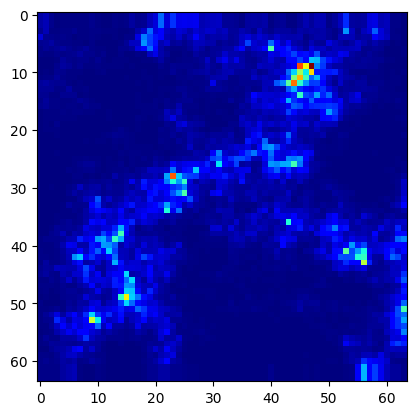

In [16]:
perm = scio.loadmat('data/TRUE_PERM_64by220.mat')
m_full = torch.tensor(perm['TRUE_PERM'],dtype=torch.float32).to(device)
m = 10**m_full[:Nx, 120:Ny+120]
m = m.reshape(1, 64, 64)
print('m shape is ', m.shape)
plt.imshow(m.detach().cpu().numpy().squeeze())

# m_eval = np.repeat(np.expand_dims(m, axis = 0), state_t_eval.shape[0], axis = 0)
m_eval = torch.unsqueeze(m, axis = 0).repeat(STATE_eval[0].shape[0], 1,1,1)
print("m_eval shape is ", m_eval.shape)

# m = np.repeat(np.expand_dims(m,axis = 0), state_t_train.shape[0], axis = 0)
m_train = torch.unsqueeze(m, axis = 0).repeat(STATE_train[0].shape[0], 1,1,1)
print("m shape is ", m.shape)

In [17]:
# ## used to generate log directory
# currentDT = datetime.now()
# current_time = str(currentDT).replace(" ", "-")[:-10]
# print(current_time)
# summary_writer = tf.summary.create_file_writer('logs/' + case_name + case_suffix + '_ep' + str(epoch) + '_tr' + str(n_train_run) + '_' + current_time)

# @tf.function
def write_summary(value, tag, writer, global_step):
    with writer.as_default():
        tf.summary.scalar(tag, value, step=global_step)

## Start training process

In [18]:
best_loss = 1.0e9
# with tf.device(device):
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        
        X_batch  = [state[ind0:ind0+batch_size, ...] for state in STATE_train]
        U_batch = [bhp[ind0:ind0 + batch_size, ...] for bhp in BHP_train]
        Y_batch = [yobs[ind0:ind0 + batch_size, ...] for yobs in Yobs_train]
        m_batch  = m_train[ind0:ind0 + batch_size, ...]
        dt_batch  = dt_train[ind0:ind0 + batch_size, ...]
        
        # inputs = (X_batch, U_batch, Y_batch, dt_batch, m_batch)
        inputs = (X_batch, U_batch, Y_batch, dt_batch)
        # labels = state_t1_batch

        my_rom.update(inputs)

        n_itr = e * num_train + ib * batch_size + batch_size
#             write_summary(my_rom.train_loss.result(), 'train/total_loss', summary_writer, n_itr) # log for tensorboard
#             write_summary(my_rom.train_reconstruction_loss.result(), 'train/reconstruction_loss', summary_writer, n_itr) # log for tensorboard
#             write_summary(my_rom.train_flux_loss.result(), 'train/flux_loss', summary_writer, n_itr) # log for tensorboard
#             write_summary(my_rom.train_well_loss.result(), 'train/well_loss', summary_writer, n_itr) # log for tensorboard
#             summary_writer.flush()

        if ib % 300 == 0:
#             print('Epoch %d/%d, Batch %d/%d, Loss %f,' % (e+1, epoch, ib+1, num_batch, my_rom.train_loss.result()))
            print('Epoch %d/%d, Batch %d/%d, Loss %f,' % (e+1, epoch, ib+1, num_batch, my_rom.train_loss))
            X_batch_eval = [state for state in STATE_eval]
            U_batch_eval = [bhp for bhp in BHP_eval]
            Y_batch_eval = [yobs for yobs in Yobs_eval]
            m_batch_eval  = m_eval
            # test_inputs = (X_batch_eval, U_batch_eval, Y_batch_eval, dt_eval, m_batch_eval)
            test_inputs = (X_batch_eval, U_batch_eval, Y_batch_eval, dt_eval)
            my_rom.evaluate(test_inputs)

#                 write_summary(my_rom.test_loss.result(), 'eval/total_loss', summary_writer, n_itr) # log for tensorboard
#                 summary_writer.flush()

    print('====================================================')
    print('Epoch %d/%d, Train loss %f, Eval loss %f' % (e + 1, epoch, my_rom.train_loss, my_rom.test_loss))
    print('====================================================')
    
    ## Save best model parameters to file
    if my_rom.test_loss < best_loss:    
        my_rom.model.save_weights_to_file(encoder_file, decoder_file, transition_file)
        best_loss = my_rom.test_loss

Epoch 1/200, Batch 1/2250, Loss 31622.802734,
Epoch 1/200, Batch 301/2250, Loss 1132.229248,
Epoch 1/200, Batch 601/2250, Loss 1091.178833,
Epoch 1/200, Batch 901/2250, Loss 554.205872,
Epoch 1/200, Batch 1201/2250, Loss 483.541565,
Epoch 1/200, Batch 1501/2250, Loss 381.053223,
Epoch 1/200, Batch 1801/2250, Loss 488.469086,
Epoch 1/200, Batch 2101/2250, Loss 403.804504,
Epoch 1/200, Train loss 353.810486, Eval loss 367.116425
Epoch 2/200, Batch 1/2250, Loss 326.802887,
Epoch 2/200, Batch 301/2250, Loss 364.933350,
Epoch 2/200, Batch 601/2250, Loss 357.376373,
Epoch 2/200, Batch 901/2250, Loss 242.855591,
Epoch 2/200, Batch 1201/2250, Loss 273.879089,
Epoch 2/200, Batch 1501/2250, Loss 198.641800,
Epoch 2/200, Batch 1801/2250, Loss 229.376038,
Epoch 2/200, Batch 2101/2250, Loss 273.947174,
Epoch 2/200, Train loss 191.869888, Eval loss 208.215027
Epoch 3/200, Batch 1/2250, Loss 208.735626,
Epoch 3/200, Batch 301/2250, Loss 279.641968,
Epoch 3/200, Batch 601/2250, Loss 264.253204,
Epoch 

# Seciton 2: E2C Test (Eval)

## Load ROM with E2C model (if you did not run section 1)

In [18]:
my_rom.model.load_weights_from_file(encoder_file, decoder_file, transition_file)

## Load and manipulate data

In [19]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = torch.tensor(np.array(hf_r.get('Mole_frac_norm_slt')).transpose((3,2,1,0)) , dtype=torch.float32)
pres = torch.tensor(np.array(hf_r.get('Psim_norm_slt')).transpose((3,2,1,0)) , dtype=torch.float32)
hf_r.close()

In [20]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = torch.tensor(np.array(hf_r.get('Pwf_norm_slt')).transpose((2,1,0)) , dtype=torch.float32)
rate0 = torch.tensor(np.array(hf_r.get('Qinj_norm_slt')).transpose((2,1,0)) , dtype=torch.float32)
hf_r.close()

In [21]:
bhp = torch.cat((bhp0,rate0),dim=1)
print(bhp.shape)

torch.Size([600, 9, 20])


In [22]:
hf_r = h5py.File(data_dir + yobs_data)
Qrate_w = torch.tensor(np.array(hf_r.get('Qpro_w_RC_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
Qrate_g = torch.tensor(np.array(hf_r.get('Qpro_g_RC_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
BHP_inj = torch.tensor(np.array(hf_r.get('BHPinj_norm_slt')).transpose((2,1,0)), dtype=torch.float32)
hf_r.close()
yobs = torch.cat((Qrate_w,Qrate_g,BHP_inj),dim=1)

In [23]:
# test_case0 = torch.tensor(np.zeros((25,4)), dtype=torch.float32)
# a = torch.tensor(np.array(range(75,400,100))[np.newaxis,:], dtype=torch.float32)
# b = torch.tensor(np.array(range(25))[:,np.newaxis], dtype=torch.float32)

# test_case = (test_case0 + a + b).T.reshape(100)
# test_case = torch.tensor(np.array(test_case).astype(int), dtype=torch.float32)

test_case0 = np.zeros((25,4))
a = np.array(range(75,400,100))[np.newaxis,:]
b = np.array(range(25))[:,np.newaxis]

test_case = (test_case0 + a + b).T.reshape(100)
test_case = np.array(test_case).astype(int)

## Pick 4 representative test cases to visualize  
Note here we have 100 test cases. In the E2C sequential workflow, prediction are done for all of them. However, to keep the notebook clean and short, we will only visualize a subset of 100.

In [24]:
ind_case = np.array([10, 25, 77, 97])

In [25]:
yobs.shape

torch.Size([600, 14, 20])

In [26]:
sat.shape

torch.Size([600, 21, 64, 64])

In [27]:
num_case = test_case.shape[0] # 4
num_tstep = 20
sat_pred = torch.tensor(np.zeros((num_case, num_tstep, 1 , Nx, Ny)), dtype=torch.float32).to(device) 
pres_pred = torch.tensor(np.zeros((num_case, num_tstep, 1, Nx, Ny)), dtype=torch.float32).to(device) 
yobs_pred = torch.tensor(np.zeros((num_case, num_tstep, num_prod*2+num_inj)), dtype=torch.float32).to(device) 

num_prod = 5
num_inj = 4
num_well = num_prod + num_inj

num_all_case = 400
num_ctrl = 20

Specify timesteps, time intervals, etc.

## Reshape the input data  
To a proper format, so that it can be easily consumed by E2C model

In [28]:
t_steps = np.arange(0,200,200//num_tstep)

dt = 10
t_steps1 = (t_steps + dt).astype(int)

indt_del = t_steps1 - t_steps
indt_del = indt_del / max(indt_del)

tmp = np.array(range(num_tstep)) - 1
tmp1 = np.array(range(num_tstep))
tmp[0] = 0

In [29]:
tmp1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [30]:
# bhp_b0 = bhp.reshape(num_all_case, num_well, num_ctrl)
# # bhp_b1 = np.repeat(bhp_b0[..., np.newaxis], num_tstep // num_ctrl, axis=3)
# bhp_b1 = bhp_b0.unsqueeze(-1).repeat(1, 1, 1, num_tstep // num_ctrl)
# assert num_tstep // num_ctrl * num_ctrl == num_tstep, "no exaxt division num_step = %d, num_ctrl=%d"%(num_tstep, num_ctrl)

# bhp_b2 = bhp_b1.reshape(num_all_case, num_well, num_tstep)

# bhp_tt = bhp_b0[:,:, tmp]
bhp_tt1 = bhp[:,:, tmp1]

# bhp_tt0 = torch.cat((bhp_tt, bhp_tt1), dim=1)
bhp_t = torch.swapaxes(bhp_tt1,1,2).to(device)

bhp_seq = bhp_t[test_case, :, :]

In [31]:
sat_t_seq = sat[test_case, 0:1, ...].to(device)
pres_t_seq = pres[test_case, 0:1, ...].to(device)

state_t_seq = torch.cat((sat_t_seq, pres_t_seq),dim=1)
state_pred = torch.cat((sat_pred, pres_pred),dim=2)

In [32]:
yobs_t_seq = torch.swapaxes(yobs[test_case,...],1,2).to(device)

In [33]:
# m_t_seq = np.repeat(np.expand_dims(m, axis = 0), state_t_seq.shape[0], axis = 0)

In [34]:
# prod_loc_t_seq = np.repeat(np.expand_dims(prod_loc, axis = 0), state_t_seq.shape[0], axis = 0)

In [35]:
m_t_seq = m.unsqueeze(0).repeat(state_t_seq.shape[0], 1, 1, 1)

In [36]:
# prod_loc_t_seq = prod_loc.unsqueeze(0).repeat(state_t_seq.shape[0], 1, 1)

## E2C sequential workflow

In [37]:
state_t_seq.shape

torch.Size([100, 2, 64, 64])

In [38]:
num_tstep

20

In [39]:
start = timeit.default_timer()

for i_tstep in range(num_tstep):
#     state_pred[:, i_tstep, ...] = state_t_seq.clone()
    state_pred[:, i_tstep, ...] = state_t_seq
    dt_seq = torch.tensor(np.ones((num_case,1)) * indt_del[i_tstep], dtype=torch.float32).to(device) 
    # m_t_seq = m_t_seq.to(device) 
    # inputs = (state_t_seq, bhp_seq[:,i_tstep,:], yobs_t_seq[:,i_tstep,:],dt_seq, m_t_seq)
    inputs = (state_t_seq, bhp_seq[:,i_tstep,:], yobs_t_seq[:,i_tstep,:],dt_seq)
    state_t1_seq, yobs_t1_seq = my_rom.predict(inputs)
    state_t_seq = state_t1_seq
    yobs_pred[:,i_tstep,:] = yobs_t1_seq

end = timeit.default_timer()
print("Time for sequential process: %f" %(end - start))

Time for sequential process: 14.641504


## Visualization

In [40]:
# sat_seq_true = sat[test_case[ind_case], ...]
sat_seq_true = sat[test_case, ...]
sat_seq_true = sat_seq_true

# pres_seq_true = pres[test_case[ind_case], ...]
pres_seq_true = pres[test_case, ...]
pres_seq_true = pres_seq_true
state_seq_true = torch.zeros((len(test_case),2,21,Nx,Ny))
state_seq_true[:,0,:,:] = sat_seq_true
state_seq_true[:,1,:,:] = pres_seq_true

In [41]:
yobs_seq_true =  torch.swapaxes(yobs[test_case,...],1,2)

### Visualization for saturation

In [42]:
s_max = 1.0
s_min = 0.0
s_diff = s_max - s_min

In [43]:
sat_pred_plot = state_pred[:, :, 0, :, :] * s_diff + s_min
state_pred[:, :, 0, :, :] = state_pred[:, :, 0, :, :] * s_diff + s_min

In [44]:
# divide = 2
# for k in range(4):
#     print("Case num: %d"%ind_case[k])
#     plt.figure(figsize=(16,5))
#     for i_tstep in range(len(t_steps)//divide):
#         plt.subplot(3, num_tstep//divide, i_tstep+1)
#         plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy())
#         plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
#         plt.xticks([])
#         plt.yticks([])
#         plt.clim([0.0, 1.0])
#         if i_tstep == 9:
#             plt.colorbar(fraction=0.046) 

Case num: 10


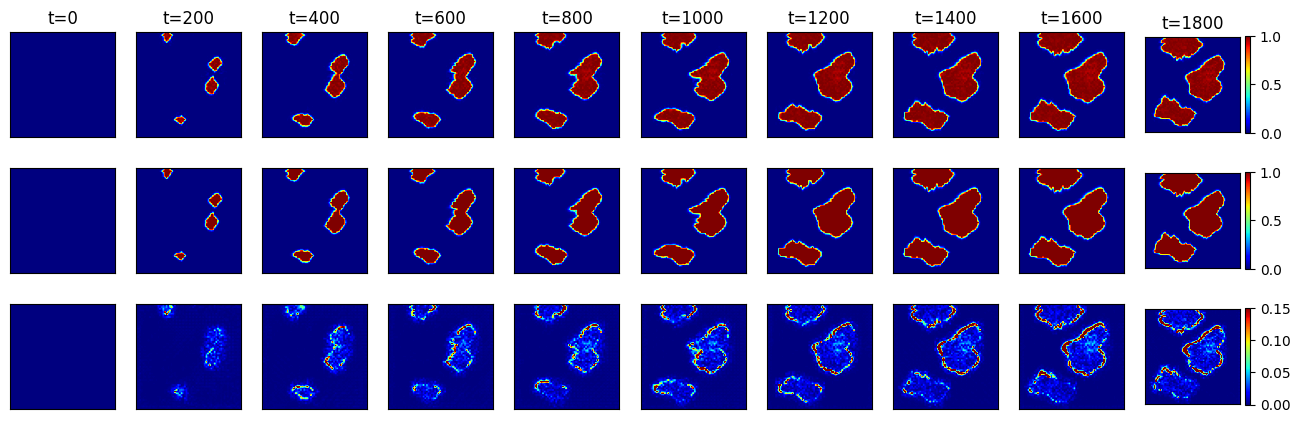

Case num: 25


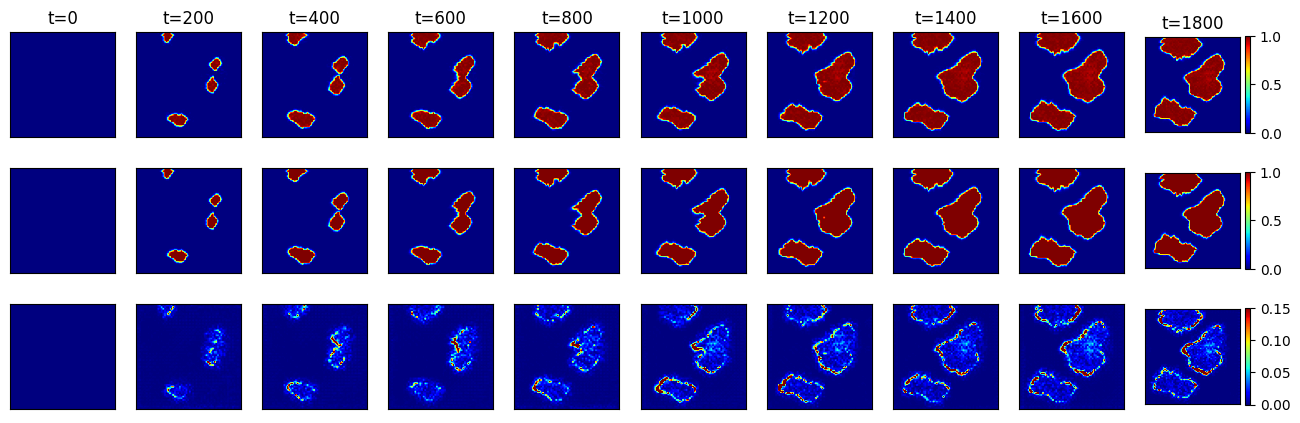

Case num: 77


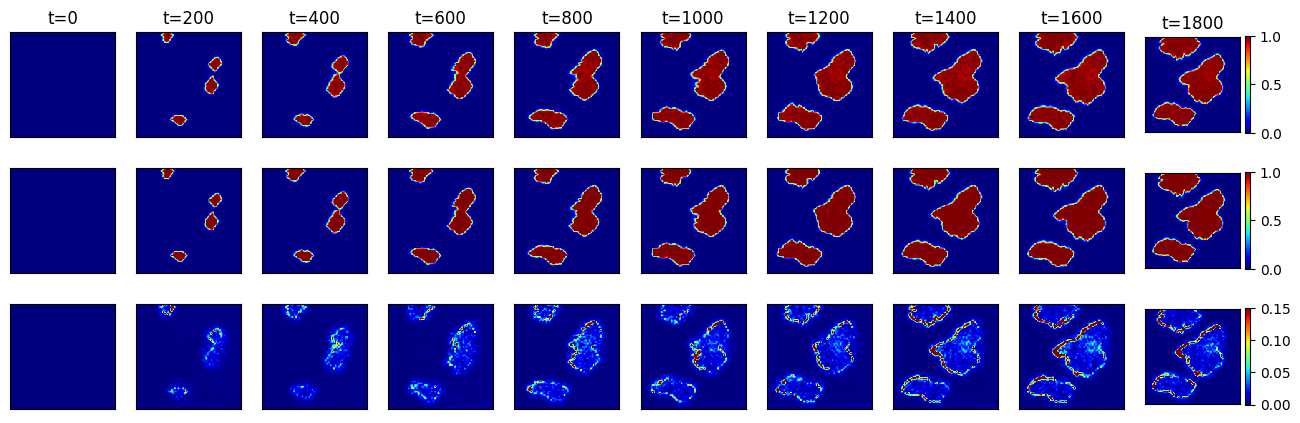

Case num: 97


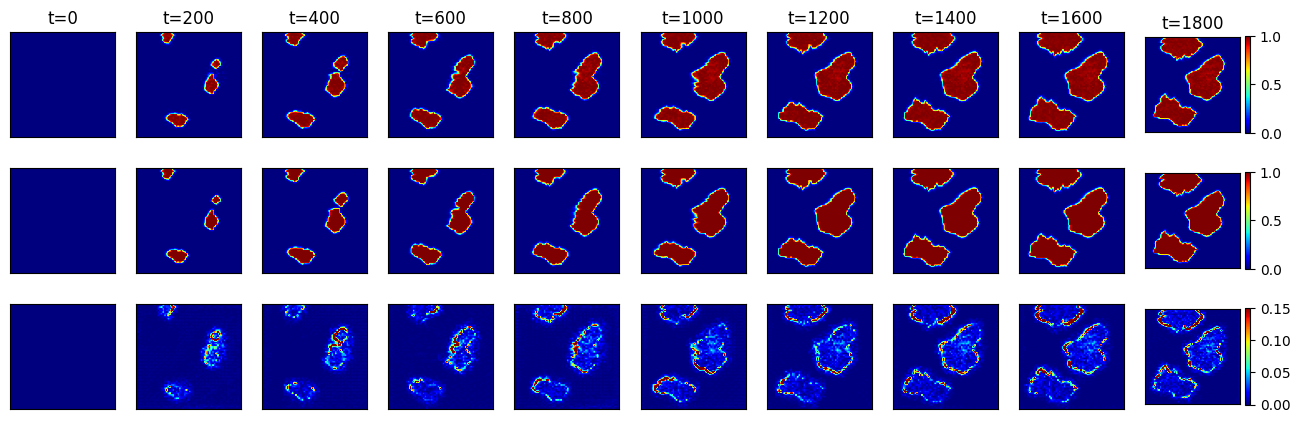

In [45]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy())
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.0, 1.0])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true[ind_case[k], 0, i_tstep*divide, :])
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.0, 1.0])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(torch.abs(state_seq_true[ind_case[k], 0, i_tstep*divide, ...] - sat_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy()))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [46]:
# from sklearn.metrics import mean_absolute_percentage_error
# divide = 1
# mape_sat = np.zeros(len(t_steps))
# plt.figure(figsize=(16,5))
# LEGENDS= [] 
# for k in range(len(test_case)):
#     # print("Case num: %d"%ind_case[k])
#     for i_tstep in range(len(t_steps)//divide):
#         # plt.subplot(1, num_tstep//divide, i_tstep+1)
#         mape_sat[i_tstep] = mean_absolute_percentage_error(state_seq_true[k, 0, i_tstep*divide, :], sat_pred_plot[k, i_tstep*divide, :,:].cpu().detach().numpy())
    
#     plt.plot(mape_sat)
#     # LEGENDS.append("Case num: {}".format(ind_case[k]))

# # plt.legend(LEGENDS)
# plt.show()

### Visualization for pressure

In [47]:
p_max = 4069.2
p_min = 2200
p_diff = p_max - p_min

In [48]:
state_pred_plot = state_pred[:, :, 1, :, :] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, 1, :, :] * p_diff + p_min

Case num: 10


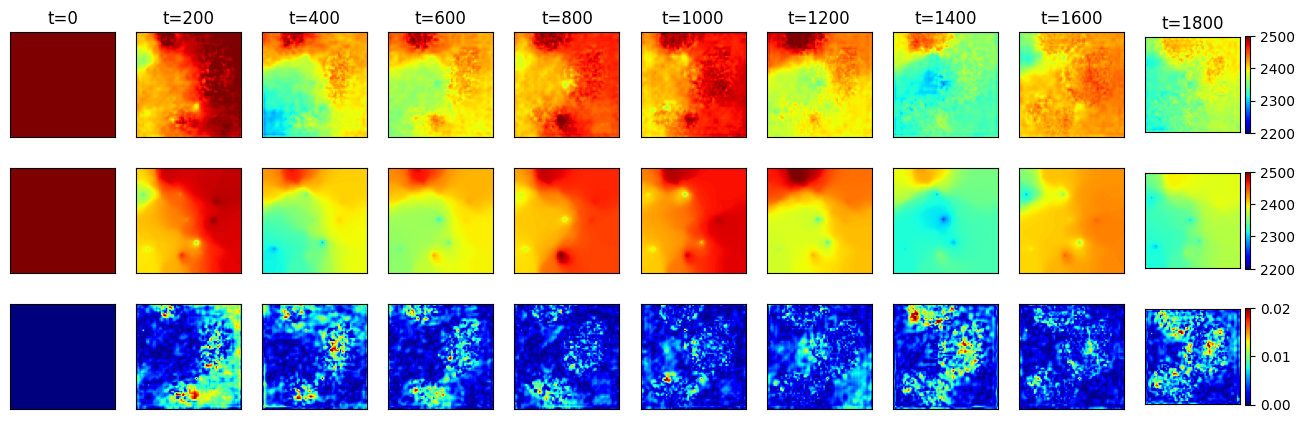

Case num: 25


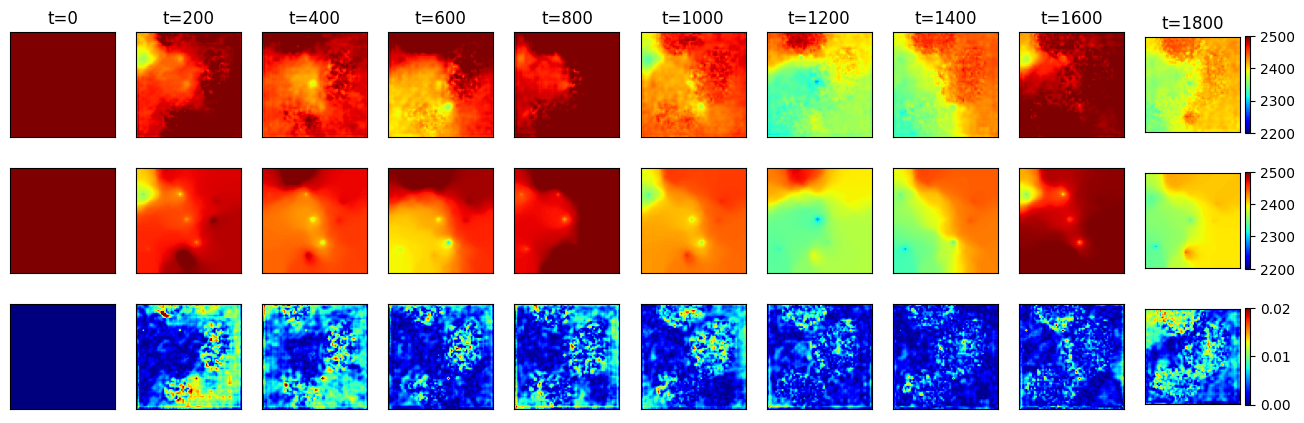

Case num: 77


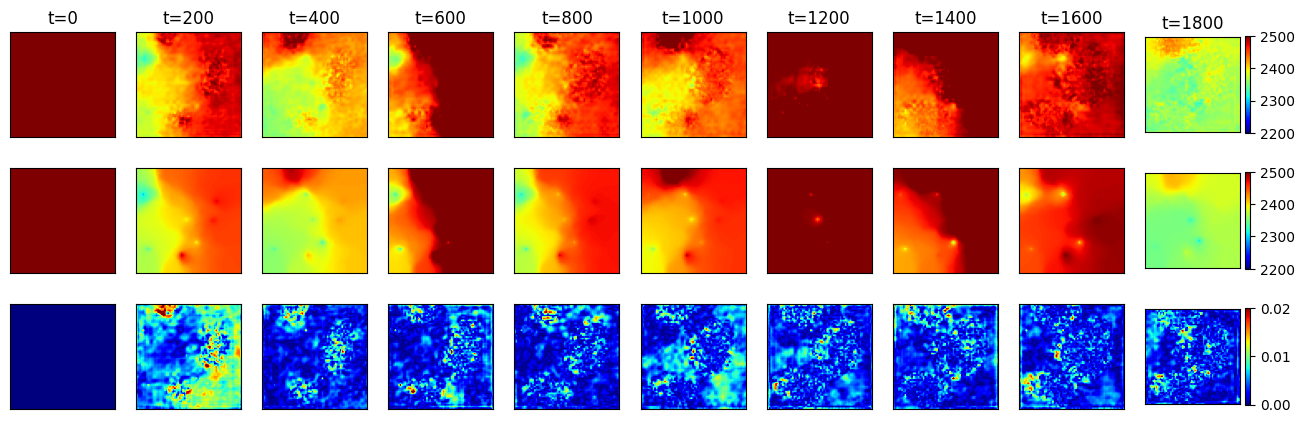

Case num: 97


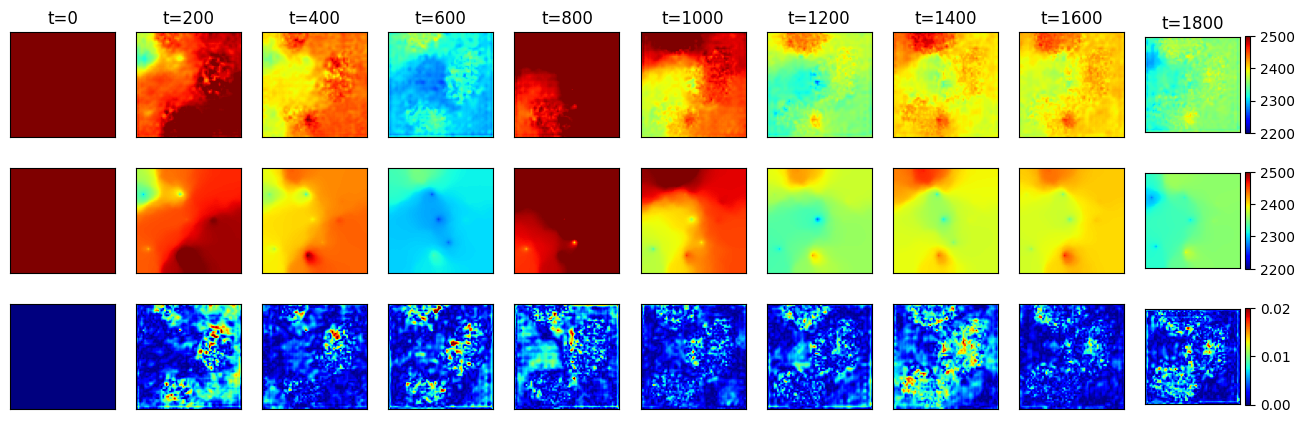

In [49]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred_plot[ind_case[k], i_tstep*divide, :, :].cpu().detach().numpy())
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([2200, 2500])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true_plot[ind_case[k], i_tstep*divide, ...])
        plt.xticks([])
        plt.yticks([])
        plt.clim([2200, 2500])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true_plot[ind_case[k], i_tstep*divide, ...] - state_pred_plot[ind_case[k], i_tstep*divide, :,:].cpu().detach().numpy())/state_seq_true_plot[ind_case[k], i_tstep*divide, ...])
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [50]:
# divide = 1
# mape_pres = np.zeros(len(t_steps))
# plt.figure(figsize=(16,5))
# LEGENDS= [] 
# for k in range(len(test_case)):
#     # print("Case num: %d"%ind_case[k])
#     for i_tstep in range(len(t_steps)//divide):
#         # plt.subplot(1, num_tstep//divide, i_tstep+1)
#         mape_pres[i_tstep] = mean_absolute_percentage_error(state_seq_true_plot[k, i_tstep*divide, :], state_pred_plot[k, i_tstep*divide, :, :].cpu().detach().numpy())
    
#     plt.plot(mape_pres)
#     # LEGENDS.append("Case num: {}".format(ind_case[k]))

# # plt.legend(LEGENDS)
# plt.show()

### Visualization for observations

In [51]:
Q_min = 0
Q_max = 2381.9
Q_diff = Q_max - Q_min

In [52]:
yobs_pred[:,:,:2*num_prod] = yobs_pred[:,:,:2*num_prod]*Q_diff+Q_min
yobs_seq_true[:,:,:2*num_prod] = yobs_seq_true[:,:,:2*num_prod]*Q_diff+Q_min
yobs_pred[:,:,2*num_prod:] = yobs_pred[:,:,2*num_prod:]*p_diff+p_min
yobs_seq_true[:,:,2*num_prod:] = yobs_seq_true[:,:,2*num_prod:]*p_diff+p_min

In [53]:
yobs_pred.shape

torch.Size([100, 20, 14])

In [54]:
yobs_seq_true.shape

torch.Size([100, 20, 14])

Well num: 1


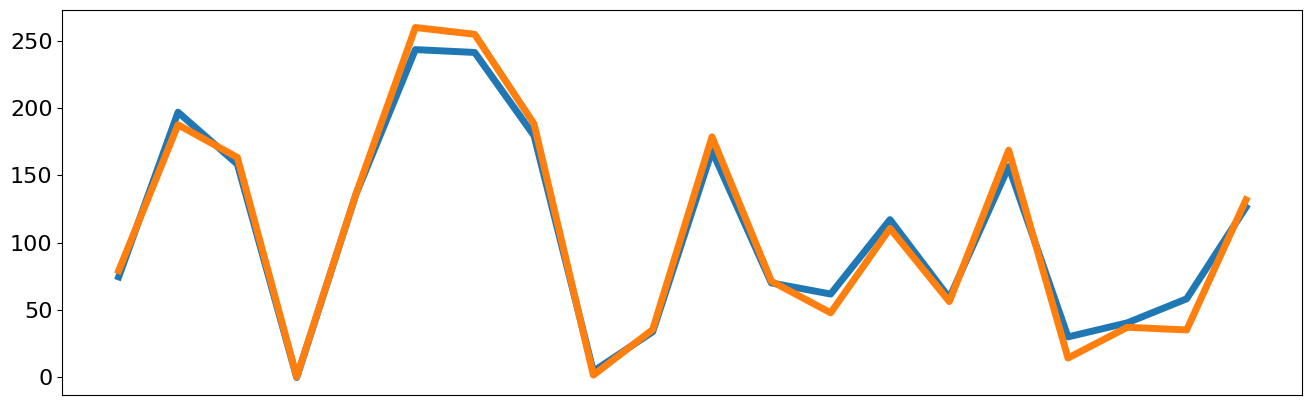

Well num: 2


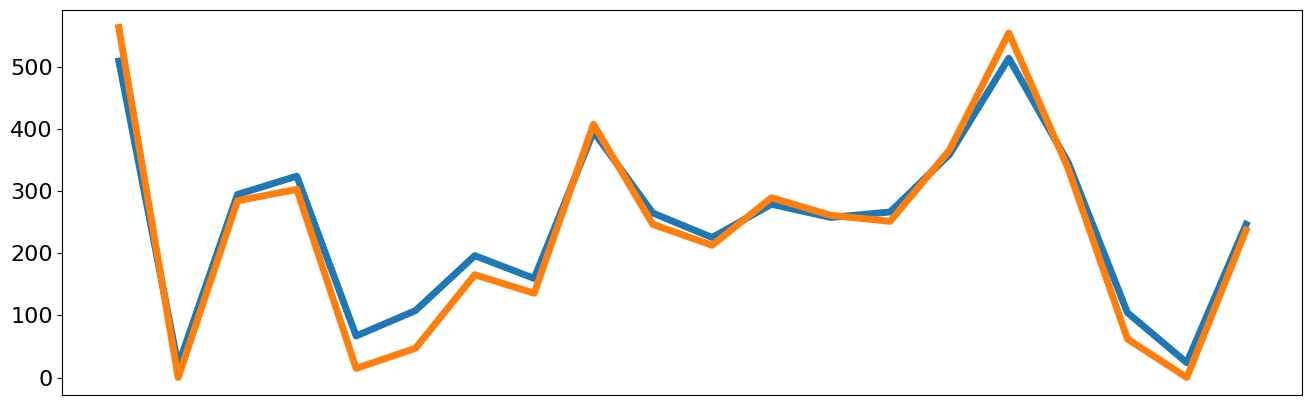

Well num: 3


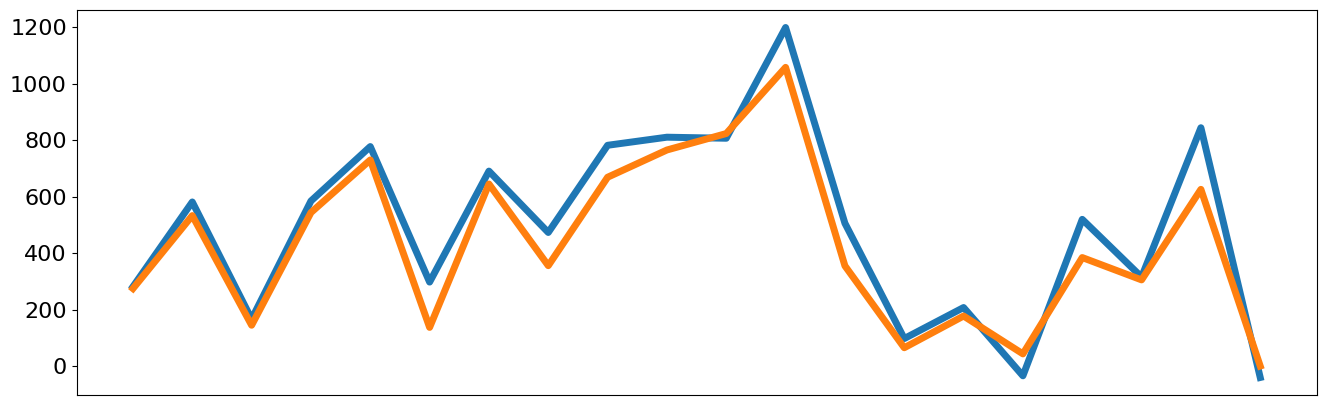

Well num: 4


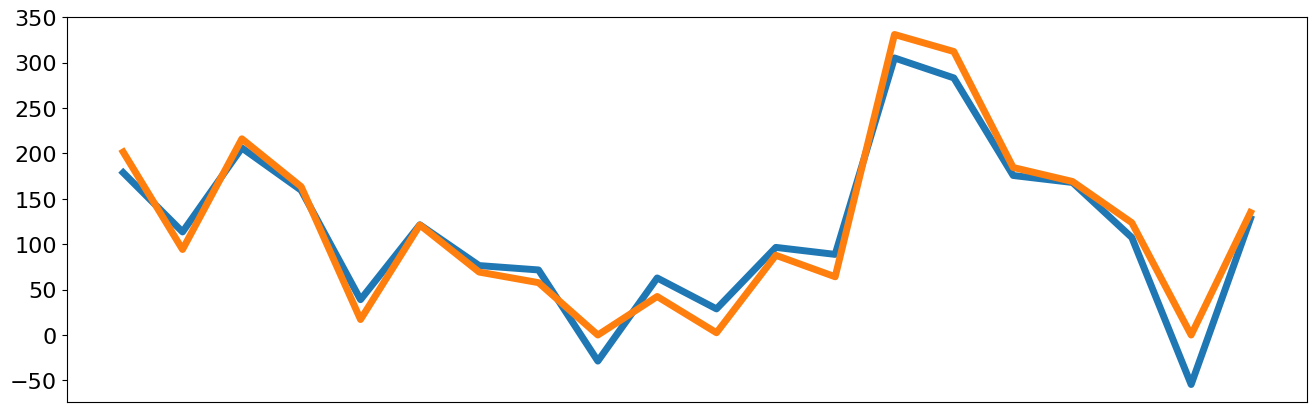

Well num: 5


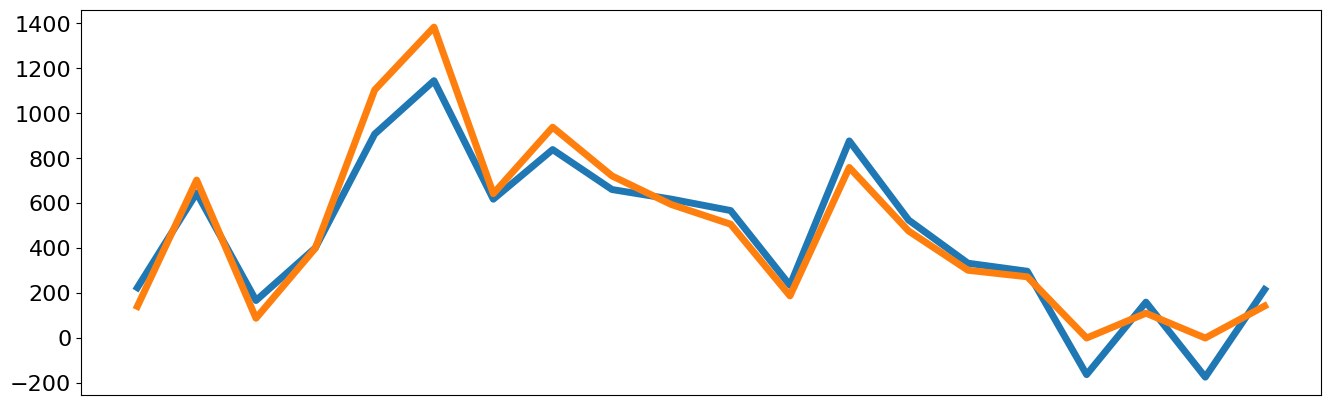

Well num: 6


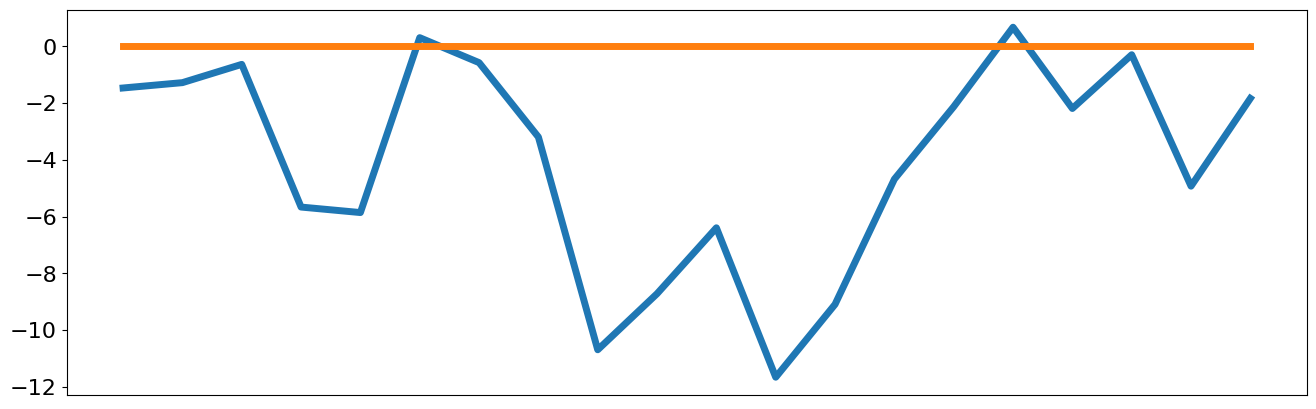

Well num: 7


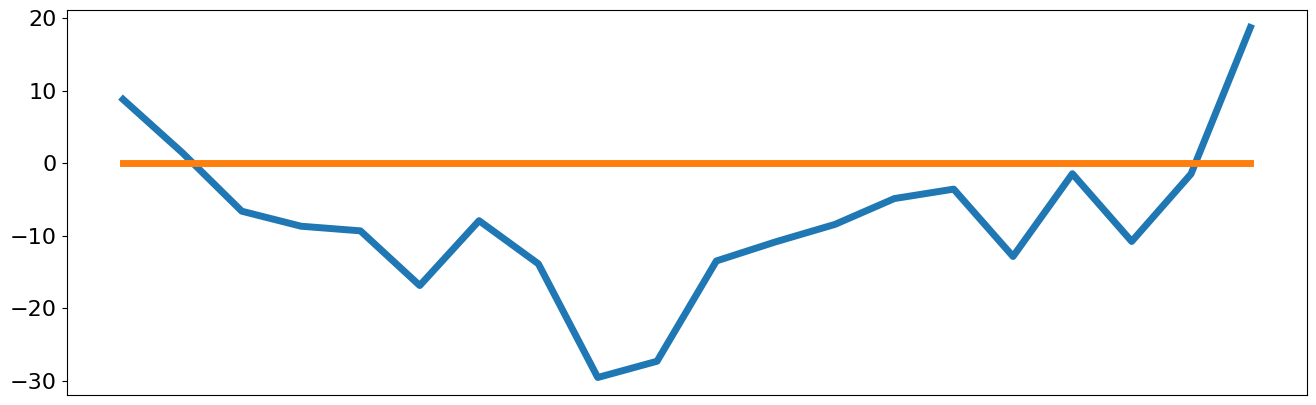

Well num: 8


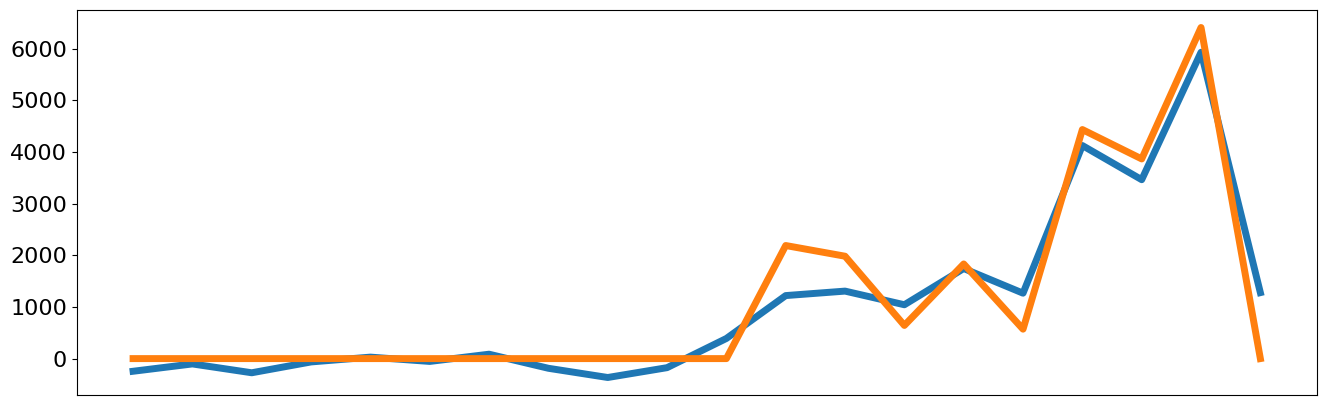

Well num: 9


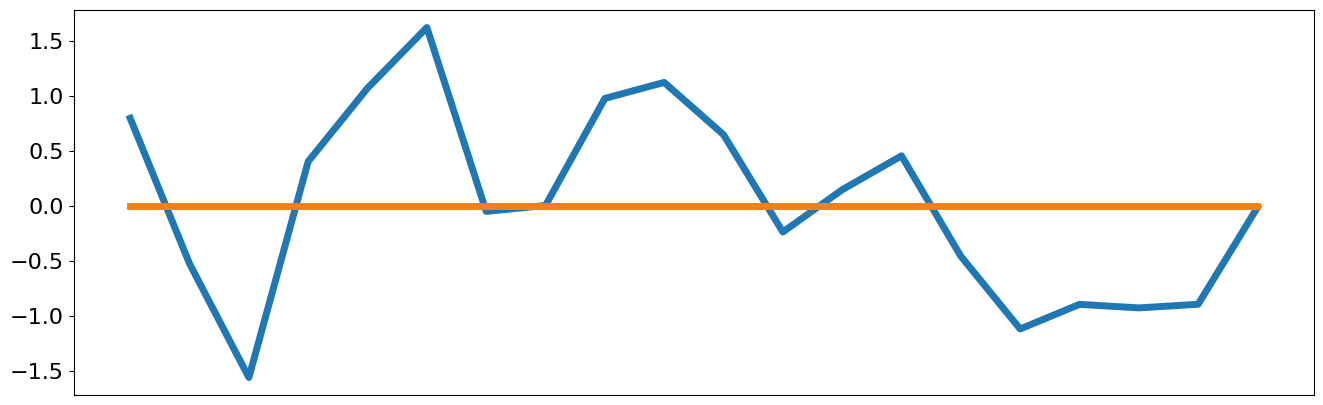

Well num: 10


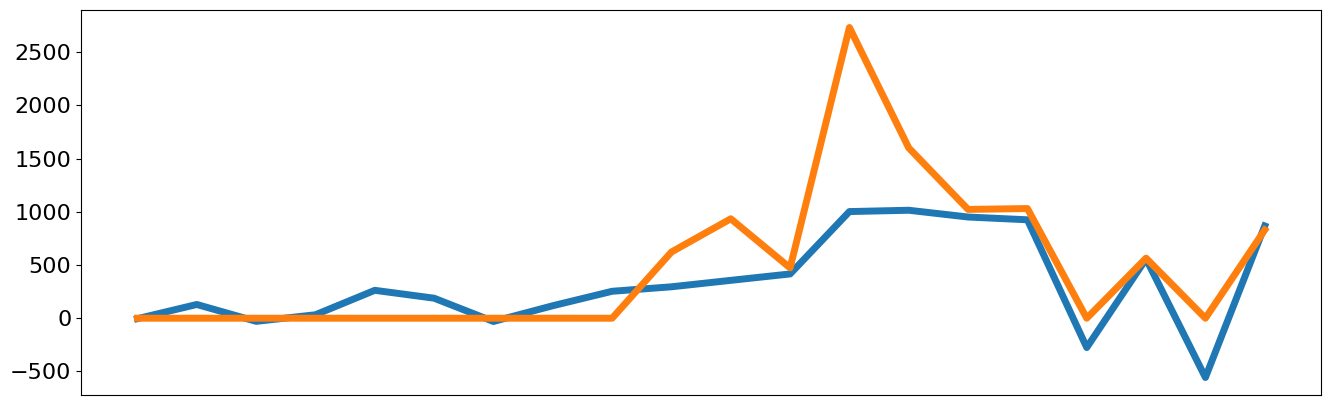

Well num: 11


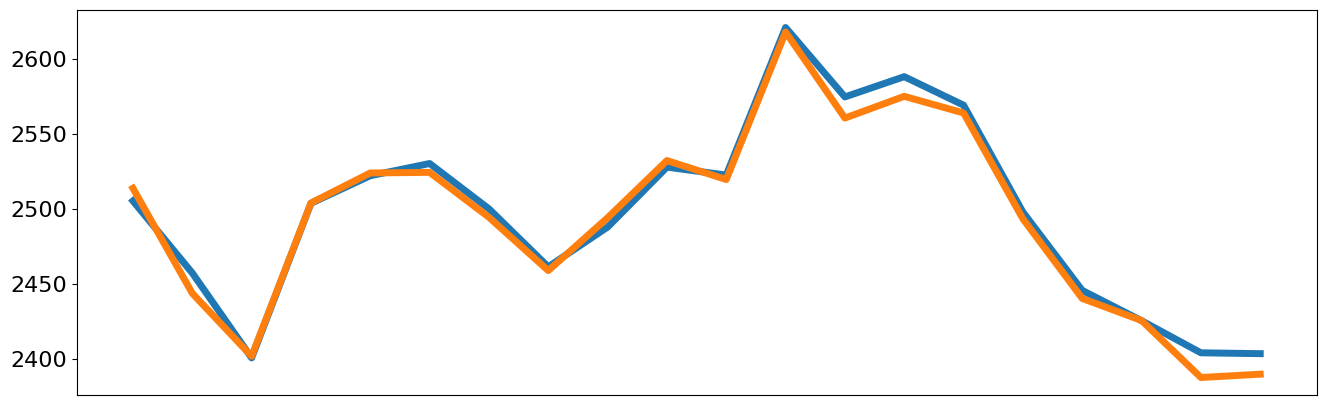

Well num: 12


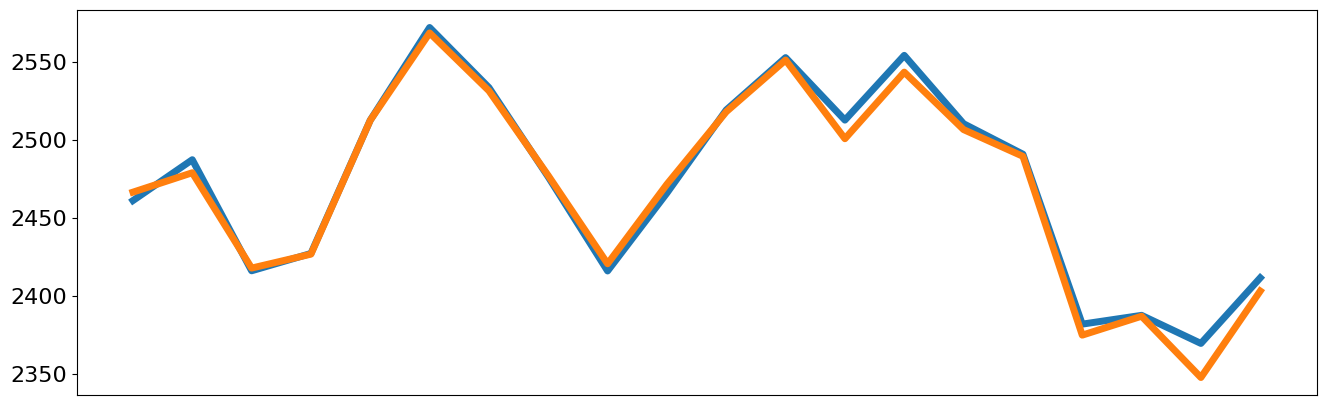

Well num: 13


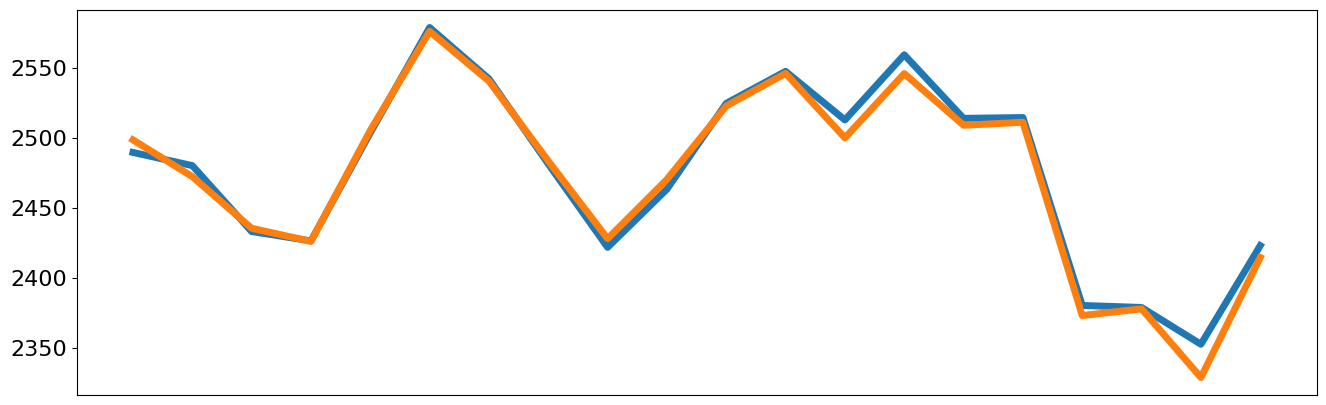

Well num: 14


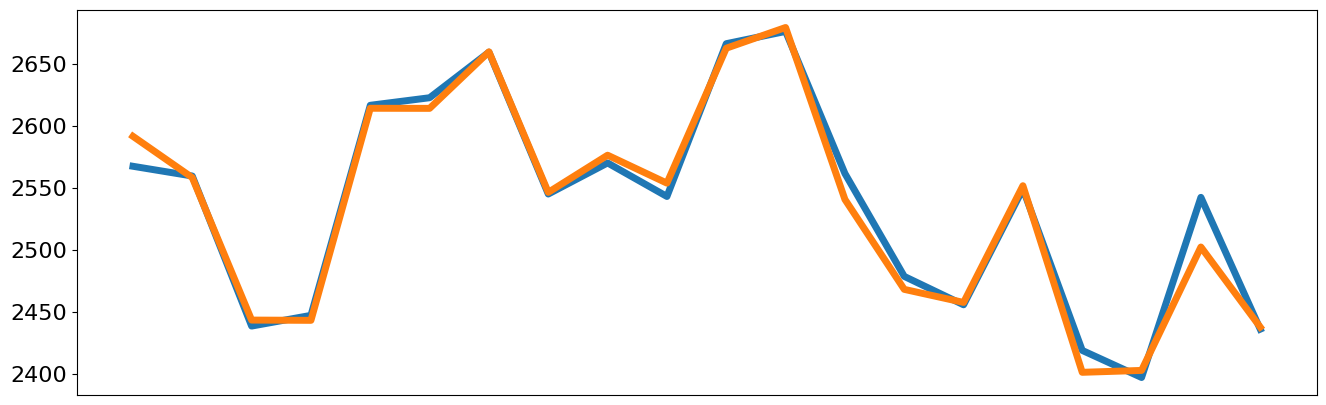

In [65]:
for i_well in range(yobs_pred.shape[-1]):
    print("Well num: %d"%(i_well+1))
    plt.figure(figsize=(16,5))
    # for i_tstep in range(len(t_steps)//divide):
    # plt.subplot(3, num_tstep//divide, i_tstep+1)

    plt.plot(np.arange(20), yobs_pred[77, :, i_well].cpu().detach().numpy(),linewidth=5.0)

    plt.plot(np.arange(20), yobs_seq_true[77, :, i_well],linewidth=5.0)
    plt.xticks([])
    # new_list = range(0, 20)
    # plt.xticks(new_list,fontsize=16)
    plt.yticks(fontsize=16)
    # plt.clim([0.1, 0.7])    

    plt.show()
